First we follow the guide at https://aws.amazon.com/blogs/machine-learning/build-tune-and-deploy-an-end-to-end-churn-prediction-model-using-amazon-sagemaker-pipelines/ to preprocess the data and return it as a pandas dataframe.

In [3]:
import boto3
import pandas as pd
import numpy as np

## Preprocess the dataset
def preprocess_data(file_path):  
  df = pd.read_csv(file_path)
  ## Convert to datetime columns
  df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
  ## Drop Rows with null values
  df = df.dropna()    
  ## Create Column which gives the days between the last order and the first order
  df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
  ## Create Column which gives the days between when the customer record was created and the first order
  df['created'] = pd.to_datetime(df['created'])
  df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
  ## Drop Columns
  df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
  ## Apply one hot encoding on favday and city columns
  df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
  return df

## Set the required configurations
model_name = "churn_model"
env = "dev"
## S3 Bucket
default_bucket = "sagemaker-studio-975049910566-xx42t2smsb"
## Preprocess the dataset
storedata = preprocess_data(f"s3://{default_bucket}/data/storedata_total - data.csv")

storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,1,0,0,0,0,0,0,1,0,0


Following the guide, we will start by splitting the dataset into train, test, and validation sets and saving these dataframe subsets into S3.

In [4]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

# Split dataset
feature_names,train,validation,test = split_datasets(storedata)

# Save datasets in Amazon S3
pd.DataFrame(train).to_csv(f"s3://{default_bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{default_bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{default_bucket}/data/test/test.csv",header=False,index=False)

I'm going to check the S3 bucket and see that these files and subdirectories were created.

They in fact were!

We move onto the next step mentioned in the guide where we train, tune, and find the best candidate model with the following code:

In [5]:
# Training and Validation Input for SageMaker Training job
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

# Hyperparameter used
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

# Use the built-in SageMaker algorithm

sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(
estimator, objective_metric_name,
hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

# Tune
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

## Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)
## 10 training jobs have completed

## Get the best training job

from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

NameError: name 'TrainingInput' is not defined

Whoops! We forgot to import several classes called in the code. We will refer to the GitHub repo pointed to in the guide to clarify where these classes are imported from and add those import statements to our code. These classes are HyperparameterTuner, ContinuousParameter, IntegerParameter and TrainingInput. We also need to import the sagemaker module.

In [8]:
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter
import sagemaker

# Training and Validation Input for SageMaker Training job
s3_input_train = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{default_bucket}/data/validation/",content_type="csv")

# Hyperparameter used
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

# Use the built-in SageMaker algorithm

sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sagemaker_session
)

hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"
tuner = HyperparameterTuner(
estimator, objective_metric_name,
hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

# Tune
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

## Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)
## 10 training jobs have completed

## Get the best training job

from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................!
10 training jobs have completed
Best Model found so far:
{'CreationTime': datetime.datetime(2024, 2, 13, 21, 7, 1, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9808650016784668},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 2, 13, 21, 7, 45, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:975049910566:training-job/sagemaker-xgboost-240213-2103-003-7f0aa520',
 'TrainingJobName': 'sagemaker-xgboost-240213-2103-003-7f0aa520',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 2, 13, 21, 7, 8, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.8795745092273266',
                          'eta': '0.31437690038604815',
                          'max_depth': '4',
                          'min_child_we

Referring to Customer_Churn_Modeling.ipynb, we need to run the following code block to declare what region and role are. Then we will rerun the above.

In [7]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


Now we should explore what insights we can gain about the model training process as well as what the model learned from the data. What questions can we ask?

Here are some:

1. How did train and validation accuracy change over training iterations and did overfitting occur? If so where did it start to happen?

2. For some of the other models that ended up being less accurate, how much less accurate were they? Would they have maybe benefitted from more training iterations? I am thinking in particular about candidates with lower learning rates.

^^The code samples provided in the demo don't explore the other models so we probably won't focus on answering this.

3. Using the most accurate model, which data points in the VALIDATION set had failed predictions? Can we come up with good reasons why predictions for them failed? Would they be considered outliers or anomalies when compared to the training set? What insights can we derive? 

^^The code provided in Github doesn't delve this deeply so we may not be able to answer this / this may be outside the scope of this assignment. We can always come back to it though. 

4. What did the model learn from the data? What are the most significant indicators of whether a customer will churn or not?

We will follow along with the code provided in the guide and the Github repo to answer some of these questions.

As stated in the guide, we can use Amazon SageMaker Debugger for offline model analysis. Let's follow along with the code in GitHub that uses the debugger to analyze the results of the training process.

In [10]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]
print(best_hyperparameters)

{'alpha': '0.8795745092273266', 'eta': '0.31437690038604815', 'max_depth': '4', 'min_child_weight': '5.79517036312225'}


In [15]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{default_bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-02-13-21-22-38-325


Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

We haven't yet imported the required classes from the sagemaker.debugger module so let us do that and rerun the above. We also need to import the 'time' module.

In [14]:
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
import time

In [16]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:975049910566:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-908fa19f',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 2, 13, 21, 28, 22, 102000, tzinfo=tzlocal())}]

In [17]:
from smdebug.trials import create_trial

s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-02-13 21:29:38.347 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:1392 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-02-13 21:29:38.364 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:1392 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-975049910566-xx42t2smsb/debugger/demo-smdebug-xgboost-churn-classificati-2024-02-13-21-22-38-325/debug-output


Let's check to make sure this debug-output folder was created inside our S3 bucket. It was!

In [18]:
trial.tensor_names()

[2024-02-13 21:32:45.673 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:1392 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-02-13 21:32:46.693 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:1392 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_impo

In [19]:
trial.tensor("average_shap/f1").values()

{0: array([-0.00024141], dtype=float32),
 5: array([0.00890648], dtype=float32),
 10: array([0.00367099], dtype=float32),
 15: array([0.04417183], dtype=float32),
 20: array([0.07130626], dtype=float32),
 25: array([0.06434194], dtype=float32),
 30: array([0.06962827], dtype=float32),
 35: array([0.1054581], dtype=float32),
 40: array([0.13478619], dtype=float32),
 45: array([0.13640136], dtype=float32),
 50: array([0.13771795], dtype=float32),
 55: array([0.14205569], dtype=float32),
 60: array([0.15497182], dtype=float32),
 65: array([0.14712746], dtype=float32),
 70: array([0.14924869], dtype=float32),
 75: array([0.14084716], dtype=float32),
 80: array([0.14620125], dtype=float32),
 85: array([0.14440161], dtype=float32),
 90: array([0.14488448], dtype=float32),
 95: array([0.15397106], dtype=float32)}

With this we see that our invocation of sagemaker dubugger was indeed able to gather a recording of our chosen metrics every 5 rounds of training, or boosting, of our model. Now we need to define some functions that will allow us to plot these metrics to gain insight into how the training process went.

In [27]:
import regex as re # this is needed otherwise we run into NameError
from itertools import islice # also previously undefined

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

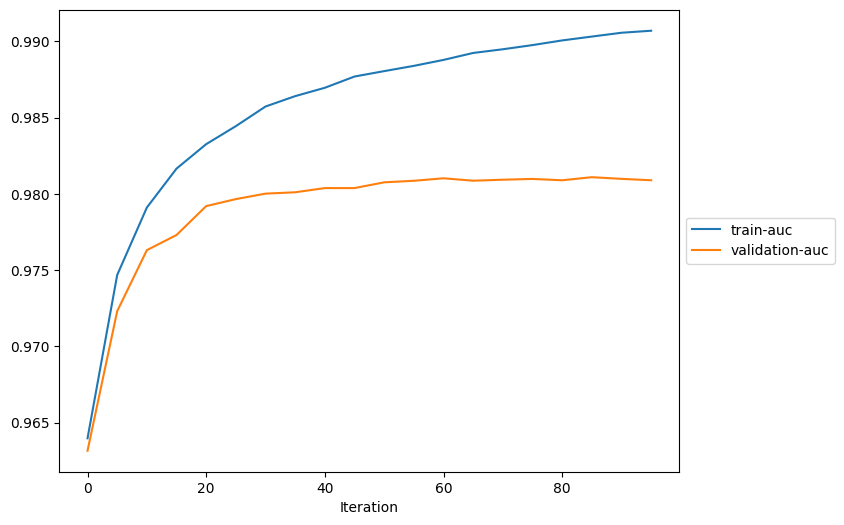

In [28]:
import matplotlib.pyplot as plt
plot_collection(trial, "metrics")

We need to install matplotlib to our environment and then rerun the above code.

In [23]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 1.2 MB/s eta 0:00:00:00:01


From looking at the graph, it seems overfitting was happening from the very beginning, but really starts to become noticeable after about 10 trees, judging from the curves being close to parallel up until that point. In other words, the slope of the validation-auc curve starts to decrease much more substantially than the slope of the train-auc curve after about 10 rounds of training. That doesn't necessarily mean we should have stopped training after 10 rounds, since there is still a gain in validation accuracy after that point by training further, but we see the returns start to diminish. I would say we might want to stop after about 20 iterations to strike that balance between getting that extra bit of accuracy out of our model and not overfitting too much. This answers question #1. We will probably not get to answering question #2 or #3, though we might choose to answer #3 after retuning our model. Let's continue following the guide to answer #4 related to feature importance. 

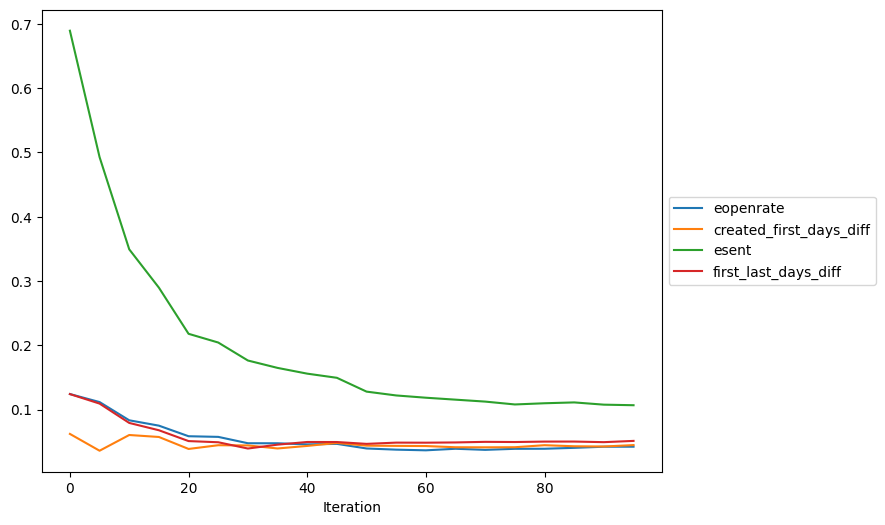

In [33]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")
    
plot_feature_importance(trial, importance_type="cover")

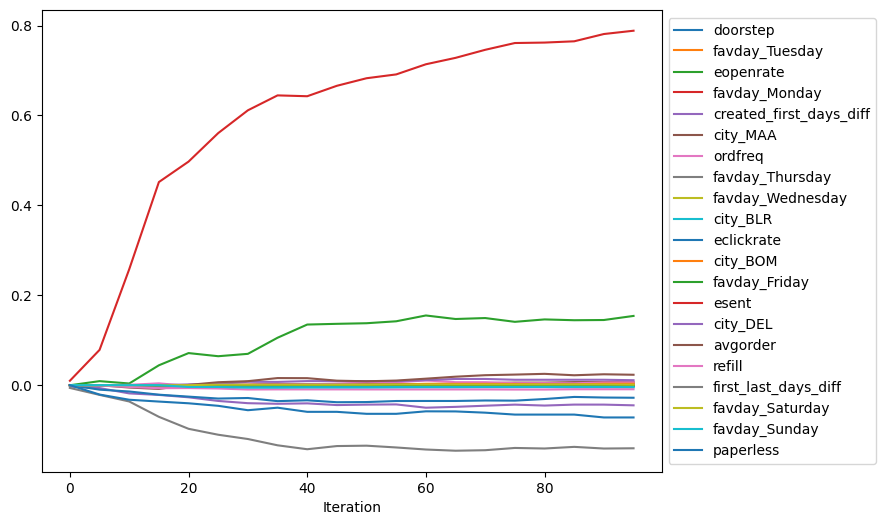

In [30]:
plot_collection(trial, "average_shap")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 23.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 26.9 MB/s eta 0:00:00:00:0100:01


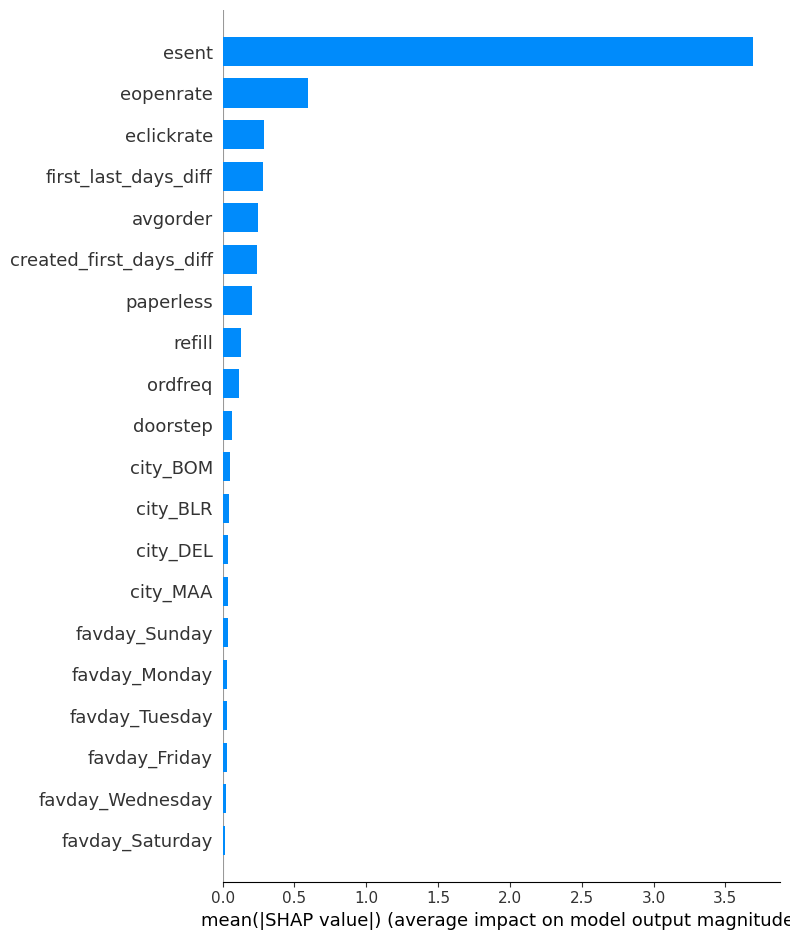

In [36]:
!pip install shap
import shap
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

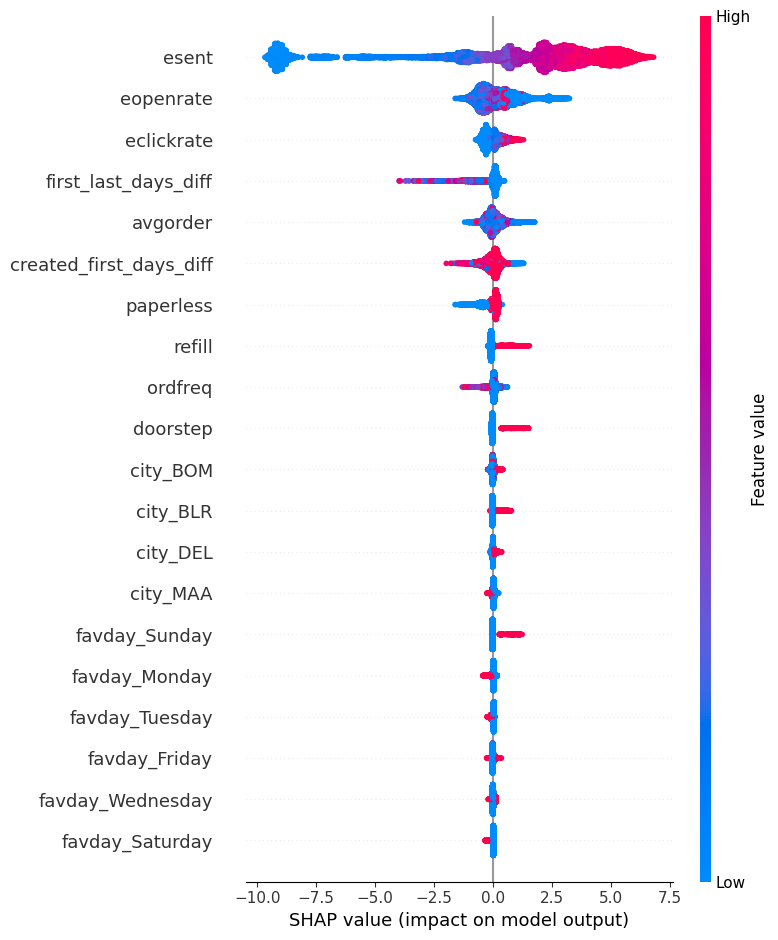

In [37]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)
shap.summary_plot(shap_no_base, train_shap)

Before we analyze the reports, it is essential to note that a predicted value of 1 means the customer will be retained and a predicted value of 0 means the customer will churn, according to the description of the target 'retained' field in the 'storedata_total - data dictionary.csv' file. 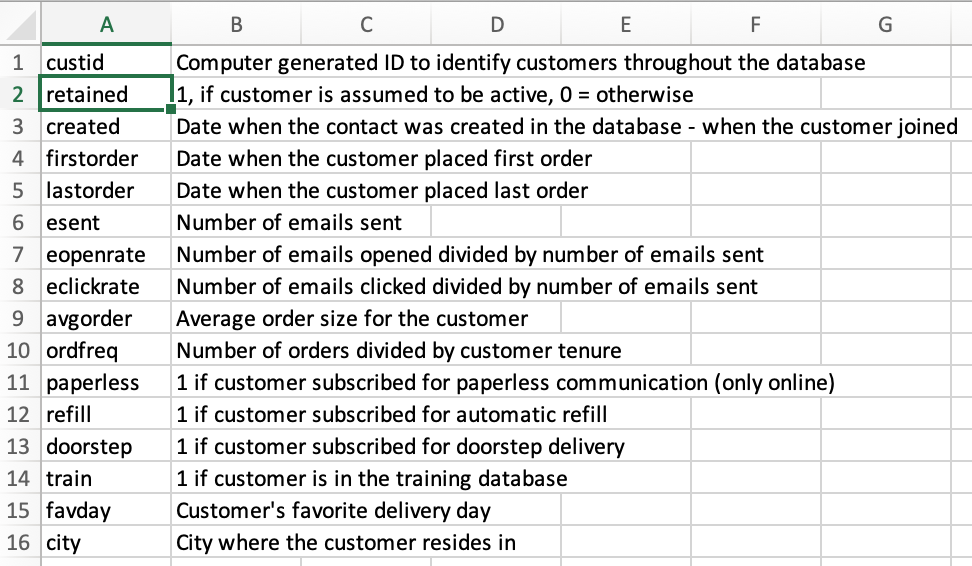

Given this, we can make a few claims about what the model learned: 

1. Trying to make sense of all the charts combined, I would select the most important indicators of whether a customer will churn, in order of importance, as the following: 

    1. Number of emails sent - more emails strongly indicative of retention 
    2. Number of emails opened divided by number of emails sent - high open rate strong association with retention. Or you could say low open rate is even more strongly associated with churn rather than saying the former. 
    3. Number of emails clicked divided by number of emails sent - high click rate moderate association with retention, or low rate is even more strongly associated with churn.
    4. The difference between first and last order date - large value somewhat associated with churn (maybe has to do with the probability of retaining business with any given customer going down as time goes on). May make more sense to say newer customers mildly associated with retention.
    5. Average order size for the customer - larger average order size slighly associated with retention
    6. Difference between date the customer joined and date of customer's first order - this one hard to interpret.
    7. Whether or not the customer subscribed for paperless communication - there is an association of this subscription with retention, but it is not strong
    8. Whether or not the customer subscribed for automatic refill - association between automatic refill and retention with indication strength varying substantially depending on the situation
    9. Number of orders divided by customer tenure - a high order frequency is associated with churn, strangely, which might be because the service eventually became too expensive for the customer and they sought a different supplier. Seems to be situational and densest part seems to be centered on 0.
    
    I am no expert so I am guessing that for the last chart, skinnier/more spread out distributions suggest that the effect of the feature can be quite situational whereas more dense distributions of SHAP value indicate that our generalizations about how much a high or low value of the feature is associated with churn or retention apply much more strongly, unless the dense part is centered on a SHAP value of 0, in which case that region of the distribution tells us nothing. Notice how for esent, very dense parts of the distribution are centered far away from 0 and have opposite colors on opposite ends? My claim is that this means the generalization that a high esent value is associated with retention and a low value is associated with churn applies strongly to the data set, particularly because we know our model to be accurate. 

We have done a fair amount of data analysis. Let us move on to the model pipeline deployment phase. We may want to optimize or retune our model if necessary. We will continue to follow along with the guide/GitHub repo.

In [38]:
!pwd

/root


In [39]:
!ls

Customer_Churn_Modeling.ipynb  Untitled.ipynb  data  model-server


We will now copy the project structure of the demo and attempt to reproduce some working automation. After verifying that the automation works, I'll probably create a Github repo for the whole project and submit a link to that repo for the bootcamp assignment submission. 